In [1]:
from numpy import *
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.special import *
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from matplotlib import patches
import warnings
import math

In [36]:
my_inf=1e6
def my_log(m):
    res = log(m, out=np.zeros_like(m), where=(m>0))
    return res
def my_tanh(x):
    mask = x<=0
    y = my_inf*(x**2)
    y[mask] = 0
    return y

def return_arc_length(points, center, r): # so far calculating euclidean distance!!!!!!!!!!!!!!
    x1, y1 = points[0]
    x2, y2 = points[1]
    c_x, c_y = center
    if x1==x2 and y1==y2:
        return 0.0
    # Calculate the distance between the center of the circle and the line segment
    dist = np.abs((y2 - y1) * c_x - (x2 - x1) * c_y + x2 * y1 - x1 * y2) / np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    # Check if the distance is less than or equal to the radius
    if dist < r:
        d = 2 * np.sqrt(r ** 2 - dist ** 2)
        l = 2*r*math.atan(d/math.sqrt(4*r**2-d**2+1e-10))
        return l-d
    else:
        return 0.0
def add_block_dist(center,r):
  return lambda u,v:return_arc_length([u,v],center,r)
# Function to check if line segment intersects circle and calculate intersection points
def line_circle_intersection(circle_center, radius, line_start, line_end):
    circle_center = np.array(circle_center)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    d = line_end - line_start
    f = line_start - circle_center
    a = np.dot(d, d)
    b = 2 * np.dot(f, d)
    c = np.dot(f, f) - radius**2
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return None

    discriminant = np.sqrt(discriminant)
    t1 = (-b - discriminant) / (2 * a+1e-8)
    t2 = (-b + discriminant) / (2 * a+1e-8)

    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return None

    intersection1 = line_start + t1 * d
    intersection2 = line_start + t2 * d

    return intersection1, intersection2

# Function to calculate the shorter arc between two points on a circle
def calculate_shorter_arc(circle_center, radius, point1, point2):
    def to_polar(point):
        x, y = point - circle_center
        return np.arctan2(y, x)

    theta1 = to_polar(point1)
    theta2 = to_polar(point2)

    if theta1 > theta2:
        theta1, theta2 = theta2, theta1

    arc_length1 = theta2 - theta1
    arc_length2 = 2 * np.pi + theta1 - theta2

    if arc_length1 < arc_length2:
        return theta1, theta2
    else:
        return theta2, theta1 + 2 * np.pi

# Function to get the path segments for each drone
def get_drone_path_segments(drone, route, stations):
    path_segments = []
    current_location = drone[0]

    for station_index in route:
        if station_index == len(stations):
            next_location = drone[1]
        else:
            next_location = stations[station_index]

        path_segments.append((current_location, next_location))
        current_location = next_location

    return path_segments
def normalize_drones(drones):
    lb=np.min([np.min((drone[0],drone[1])) for drone in drones])
    ub=np.max([np.max((drone[0],drone[1])) for drone in drones])
    normalized_drones = [(((x1 - lb) / (ub - lb), (y1 - lb) / (ub - lb)),
                          ((x2 - lb) / (ub - lb), (y2 - lb) / (ub - lb)),
                          charge)
                         for ((x1, y1), (x2, y2), charge) in drones]

    return normalized_drones, (lb,ub)

def denormalize_drones(normalized_drones, min_max_values):
    lb, ub = min_max_values

    # Denormalize coordinates
    denormalized_drones = [(((x1 * (ub - lb) + lb), (y1 * (ub - lb) + lb)),
                             ((x2 * (ub - lb) + lb), (y2 * (ub - lb) + lb)),
                             charge)
                            for ((x1, y1), (x2, y2), charge) in normalized_drones]

    return denormalized_drones
def normalize_blocks(blocks,min_max_values):
    lb, ub = min_max_values
    normalized_blocks = [(((x - lb) / (ub - lb), (y - lb) / (ub - lb)),
                          r/(ub - lb))
                         for ((x, y), r) in blocks]
    return normalized_blocks
def denormalize_blocks(blocks,min_max_values):
    lb, ub = min_max_values
    denormalized_blocks = [(((x * (ub - lb) + lb), (y * (ub - lb) + lb)),

                             r* (ub - lb))
                            for ((x, y), r) in blocks]
    return denormalized_blocks

class uav_flpo:
    def __init__(self,drones,num_stations,blocks=None,
                 ugv_factor=0.0,fcr=25,distance='euclidean') -> None:
        super().__init__()
        self.den_drones = drones
        self.drones,lb_ub = normalize_drones(drones)
        self.lb,self.ub = lb_ub
        self.scale = self.ub-self.lb
        self.stations=np.repeat([0.5,0.5],num_stations,axis=0)
        self.blocks=normalize_blocks(blocks,lb_ub)
        self.N_drones= len(drones)
        self.N_stations=num_stations
        self.stage_horizon=self.N_stations+1
        self.gamma_k_length=self.N_stations+1
        self.fcr=fcr/self.scale
        self.distance=distance
        self.ugv_factor=ugv_factor
        self.bounds = [(0, 1)]*self.N_stations*2
        self.cost_normalizer = 1/(self.N_drones*(self.N_stations**self.N_stations))
        return

    def return_stagewise_cost(self,params,beta): #params is like stations
        d_F=cdist(params,params,self.distance)
        if not self.blocks==None:
            for block in self.blocks:
                d_F=d_F+cdist(params,params,metric=add_block_dist(block[0],block[1]))
        d_F=d_F+diag([my_inf]*self.N_stations)
        d_delta_to_f=array([my_inf]*self.N_stations).reshape(1,-1)
        d_df=np.concatenate((d_F,d_delta_to_f),axis=0)
        D_ss=[0]*self.N_drones
        for drone_id,drone in enumerate(self.drones):
            stage=concatenate((params,array(self.drones[drone_id][1]).reshape(1,-1)),axis=0)
            D_s=[0]*(self.stage_horizon+1)
            stage_0=array(self.drones[drone_id][0]).reshape(1,-1)
            D_s[0]=cdist(stage_0,stage,self.distance)
            if not self.blocks==None:
                for block in self.blocks:
                    D_s[0]=D_s[0]+cdist(stage_0,stage,metric=add_block_dist(block[0],block[1]))
            #print(D_s[0]-self.drones[drone_id][2]*self.fcr)
            D_s[0]=D_s[0]+my_tanh(D_s[0]-self.drones[drone_id][2]*self.fcr)
            #D_s[0]=D_s[0]+my_exp(beta*(D_s[0]-self.drones[drone_id][2]*self.fcr))
            #D_s[0][0,-1]=D_s[0][0,-1]*(D_s[0][0,-1]>my_inf)

            delta_id= self.N_stations+drone_id
            # so far we have taken care of the first distance matrix

            d_f_to_delta=cdist(params,array(self.drones[drone_id][1]).reshape(1,-1),self.distance)
            if not self.blocks==None:
                for block in self.blocks:
                    d_f_to_delta=d_f_to_delta+cdist(params,array(self.drones[drone_id][1]).reshape(1,-1),metric=add_block_dist(block[0],block[1]))
            d_last=np.concatenate((d_f_to_delta,array([0]).reshape(1,-1)),axis=0)
            d=np.concatenate((d_df,d_last),axis=1)


            d=d+(my_tanh(d-self.fcr))
            #d=d+my_exp(beta*(d-self.fcr))
            D_s[1:self.stage_horizon] = [d] * (self.stage_horizon - 1)
            d_l=[my_inf]*(self.gamma_k_length-1)
            d_l.append(0.0)
            D_s[-1]=array(d_l).reshape(-1,1)
            D_ss[drone_id]=D_s
        self.D_ss=D_ss
        return
    def calc_associations(self,beta):
        p=[]
        self.return_stagewise_cost(self.params.reshape(-1,2),beta)
        D_ss=self.D_ss
        for D_s in D_ss:
            K=len(D_s)
            D=D_s[::-1]
            out_D=[0]*(K+1)
            out_D[0]=array([0.0]).reshape(-1,1)
            out_p=[0]*(K+1)
            out_p[0]=array([1.0]).reshape(-1,1)
            out=[0]*(K+1)
            out[0]=array([1.0]).reshape(-1,1)
            for i in range(1,K+1):
                out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))
                m=out_D[i].min(axis=1,keepdims=True)
                exp_D=exp(multiply(-beta,out_D[i]-m))
                out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
                out_p[i]=divide(multiply(exp_D,out[i-1].T),out[i])
                out_D[i]=m
            p.append(out_p[::-1][:-1])
        self.P_ss=p
        return
    def free_energy(self,D_s,P_s,beta):
        '''
        input: D_s: a list of K numpy arrays corrosponding to distances between stages
        P_s: a list of K numpy arrays corrosponding to probabilities between stages

        output: out_c: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
        '''

        K=len(D_s)
        D=D_s[::-1]
        P=P_s[::-1]
        out_P=[0]*(K+1)
        out_C=[0]*(K+1)
        out_H=[0]*(K+1)
        out_P[0]=array([1.0]).reshape(-1,1)
        out_C[0]=array([0.0]).reshape(-1,1)
        out_H[0]=array([0.0]).reshape(-1,1)
        for i in range(1,K+1):
          # assigning P of each node for calculating C in the next i
          out_P[i]=(P[i-1]*repeat(transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
          out_C[i]=(P[i-1]*(D[i-1]*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+repeat(transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
          out_H[i]=-(P[i-1]*(my_log(P[i-1])*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)-repeat(transpose(out_H[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
        # D-1/beta*H
        return (out_C[-1].T).sum() + (-1/beta)*(out_H[-1].T).sum()
    def free_energy_Gibbs(self,D_s,beta):
        K=len(D_s)
        D=D_s[::-1]
        out_D=[0]*(K+1)
        out_D[0]=array([0.0]).reshape(-1,1)
        out=[0]*(K+1)
        out[0]=array([1.0]).reshape(-1,1)
        for i in range(1,K+1):

            out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))

            m=out_D[i].min(axis=1,keepdims=True)
            exp_D=exp(multiply(-beta,D[i-1]))
            out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
            out_D[i]=m
        if isclose(out[-1],0.0).all():
            return m.sum()
        else:
            return (-1/beta*log(out[-1]).sum())

    def objective(self,params,beta):
        self.return_stagewise_cost(params.reshape(-1,2),beta)
        cost=0
        for i in range(len(self.D_ss)):
            cost+=self.free_energy_Gibbs(self.D_ss[i],beta)
        if self.ugv_factor == 0.0:
            return self.cost_normalizer*cost
        else:
            return self.cost_normalizer*cost+self.ugv_factor*linalg.norm(params.reshape(-1,2)-self.stations)

    def optimize_D(self,init_guess,beta,method):
        # bounds=(np.min([np.min(drone[0]+drone[1]) for drone in drones]),np.max([np.max(drone[0]+drone[1]) for drone in drones]))*len(init_guess)
        result = minimize(self.objective, init_guess,args=(beta,),bounds=self.bounds,method=method)
        self.params = result.x
        self.cost_fun=result.fun
    def calc_routs(self):
        O=[]
        for i in range(self.N_drones):
          m=0
          o=[]
          for p in self.P_ss[i]:
              m=argmax(p[m,:])
              o.append(m)
          o.pop()
          O.append(o)
        self.routs=O

    def train(self,beta_init=1e-6,beta_f=100,alpha=1.5,purturb=0.1,method='powell',verbos=0):
        self.Y_s=[]
        self.Betas=[]
        self.params=ndarray.flatten(self.stations)
        beta=beta_init
        # self.return_stagewise_cost(self.params.reshape(-1,2))
        old_cost=my_inf
        while beta <= beta_f:
            count=0
            self.params=self.params+np.random.normal(0, purturb, self.params.shape)

            self.optimize_D(self.params,beta,method=method) #based on P_ss
            count+=1
            if verbos:
              print(f'Beta: {beta:.4e}  Cost: {self.cost_fun:0.5e}')
            # if abs(self.cost_fun-old_cost) <= 1e-6:
            #     print("--Optimization Terminated--")
            #     break
            old_cost=self.cost_fun
            beta=beta*alpha
            self.Y_s.append(self.params.reshape(-1,2))
            self.Betas.append(beta)
        self.calc_associations(beta)
        self.calc_routs()

    def print_routs(self):
        print("")
        for i,o in enumerate(self.routs):
          print(f'\nDrone {i+1} --->', end='')
          for j in o:
            if j<env.N_stations:
              print(f'f{j+1} --->', end='')
            else:
              print(f'[D{i+1}]', end='')
              break
    def return_total_cost(self):
        return self.cost_fun*self.scale/self.cost_normalizer
    def return_direct_cost(self):
        return np.sum([np.sum((np.array(drone[0])-np.array(drone[1]))**2)**0.5 for drone in self.den_drones])
    def plot_routs(self,show_info=True,show_nums=True,save=False,show_ugv=False):
        state_locs=self.params.reshape(-1,2).copy()*self.scale+self.lb
        den_drones = self.den_drones
        drone_locs=array([i[0] for i in den_drones])
        dest_locs=array([i[1] for i in den_drones])
        plt.scatter(drone_locs[:,0],drone_locs[:,1],color='black',label='UAVs')
        for i, loc in enumerate(drone_locs):
            if show_info:
                plt.text(loc[0], loc[1], 'V'+str(i+1)+f' ({self.drones[i][2]})', ha='center', va='bottom')
        plt.scatter(state_locs[:,0],state_locs[:,1],marker='^',label='UGVs')
        f_indices = np.argsort(state_locs[:,0])
        for i, loc in enumerate(state_locs):
            if show_info:
                plt.text(loc[0], loc[1], 'F'+str(i+1), ha='center', va='bottom')
        plt.scatter(dest_locs[:,0],dest_locs[:,1],marker='*',label='Dest.')
        for i, loc in enumerate(dest_locs):
            if show_info:
                plt.text(loc[0]+1*np.random.rand()*(-1)**round(np.random.rand()), loc[1]+1*np.random.rand(), 'D'+str(i+1), ha='center', va='bottom')
        options = ['-', '--', '-.', ':',]
        modified_lines = []
        colors = []
        styles = []
        for i, o in enumerate(self.routs):

            line_style=np.random.choice(options)
            styles.append(line_style)
            drone_loc = drone_locs[i]
            try:
              state_loc = state_locs[o[0]]
            except:
              state_loc=dest_locs[i]
            color=np.random.rand(3)
            colors.append(color)
            plt.plot([drone_loc[0], state_loc[0]], [drone_loc[1], state_loc[1]], color=color,linewidth=1.5,linestyle=line_style)
            dist = np.sqrt(np.sum((drone_loc - state_loc) ** 2))
            col='red' if dist > self.drones[i][2]*self.fcr*self.scale else 'green'
            if dist >0.0:
              if show_nums:
                plt.text((drone_loc[0] + state_loc[0]) / 2, (drone_loc[1] + state_loc[1]) / 2, f'{dist:.2f}', color=col, ha='center')
            if len(o)>1:
              for j in range(len(o) - 1):
                  try:
                    loc1 = state_locs[o[j]]
                  except:
                    loc1 = dest_locs[i]
                  try:
                    loc2 = state_locs[o[j + 1]]
                  except:
                    loc2=dest_locs[i]
                  plt.plot([loc1[0], loc2[0]], [loc1[1], loc2[1]], color=color,linewidth=1.5,linestyle=line_style)
                  dist = np.sqrt(np.sum((loc1 - loc2) ** 2))
                  col='red' if dist > self.fcr*self.scale else 'green'
                  if dist>0.0:
                    if show_nums:
                      plt.text((loc1[0] + loc2[0]) / 2, (loc1[1] + loc2[1]) / 2, f'{dist:.2f}', color=col, ha='center')
        if not self.blocks==None:
            counter=0
            den_blocks = denormalize_blocks(self.blocks,(self.lb,self.ub))
            for center, radius in den_blocks:
                c_x, c_y = center
                label='Obst.' if counter==0 else None
                circle=patches.Circle(center, radius,edgecolor="white", linewidth=0.05,facecolor='grey', linestyle='-',label=label)
                circle.set_zorder(2)
                plt.gca().add_patch(circle)
                counter+=1
        ax = plt.gca()

        # Process each drone, but only draw the arcs this time
        counter = 0
        label=None
        drone_id=0
        for drone, route in zip(den_drones, self.routs):
            path_segments = get_drone_path_segments(drone, route, state_locs)
            for segment in path_segments:
                for block in den_blocks:
                    intersections = line_circle_intersection(block[0], block[1], segment[0], segment[1])
                    if intersections:
                        if counter==0:
                            label='Adj.'
                            counter +=1
                        theta_start, theta_end = calculate_shorter_arc(block[0], block[1], intersections[0], intersections[1])
                        arc = patches.Arc(block[0], 2*block[1], 2*block[1],
                                                     theta1=np.degrees(theta_start), theta2=np.degrees(theta_end),
                                                     color=colors[drone_id],linewidth=3, linestyle=styles[drone_id])
                        ax.add_patch(arc)
                    label=None
            drone_id +=1
        if show_ugv:
            plt.scatter(self.stations[0,0],self.stations[0,1],color='orange',marker='2')
            plt.text(self.stations[0,0], self.stations[0,1], 'Initial UGV location', ha='center', va='bottom')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f'M={self.N_stations} F.C.R. = {self.fcr*self.scale}')
        plt.gca().set_aspect('equal')

        if save:
          plt.savefig(f'sim res for M={self.N_stations} F.C.R. = {self.fcr*self.scale}.pdf')
        plt.show()

In [40]:
# a list of drones, each element containing two tuples,
# representing the coordinates of the initial deployment position
# the destination coordinates, and initial charge respectively
drones=[((35.0,32.0),(10.0,30.0),0.6),
        ((40.0,15.0),(8.0,3.0),0.4),
        ((20.0,4.0),(22.0,20.0),0.6),
        ((6.0,20.0),(38.0,22.0),0.6)]
drones = [
    ((10.0, 5.0), (45.0, 50.0), 0.7),  # Long distance, high charge
    ((3.0, 40.0), (50.0, 10.0), 0.5),   # Long distance, medium charge
    ((20.0, 15.0), (35.0, 35.0), 0.6),  # Moderate distance, medium charge
    ((5.0, 30.0), (25.0, 5.0), 0.4),    # Moderate distance, low charge
    ((40.0, 45.0), (10.0, 10.0), 0.8),  # Long distance, high charge
    ((30.0, 20.0), (5.0, 35.0), 0.6),   # Moderate distance, medium charge
    ((15.0, 10.0), (40.0, 40.0), 0.4),  # Moderate distance, low charge
    ((35.0, 5.0), (10.0, 45.0), 0.5),   # Long distance, medium charge
    ((25.0, 40.0), (20.0, 10.0), 0.7),  # Moderate distance, high charge
    ((45.0, 15.0), (5.0, 20.0), 0.3)    # Long distance, low charge
]
random.seed(42)  # You can choose any number as the seed
def create_similar_values(original_tuple):
    return tuple(original_value + random.uniform(-1.0, 1.0) for original_value in original_tuple)

extended_drones = []
for drone in drones:
    for _ in range(10):  # Create 9 similar sublists
        new_start = create_similar_values(drone[0])
        new_end = create_similar_values(drone[1])
        new_charge = drone[2] + random.uniform(-0.05, 0.05)
        new_drone = (new_start, new_end, new_charge)
        extended_drones.append(new_drone)
# a list of initial deployment location of charging UGVs, could be random.
# the size of the list determines the number of charging stations
print(len(extended_drones))


blocks = [
    ((30.0, 30.0), 3.0),  # Large obstacle, centrally located
    ((15.0, 25.0), 1.50),    # Smaller obstacle, near a cluster of start/destination points
    ((30.0, 10.0), 2.00),
]
fcr = 25# Full Charge Range
ugv_factor = 0 # the cost factor for UGV transportation
distance = 'euclidean' # distance measure in the environment

beta_init = 1e-8 # initial beta value for the optimization.
beta_f = 100 # final beta value for the optimization
alpha = 3 # beta growth rate
purturb = 0.001 # random purturbation in optimization

env=uav_flpo(drones,4,blocks=blocks,
             ugv_factor=ugv_factor,fcr=fcr,distance=distance)
env.train(beta_init=beta_init,beta_f=beta_f,alpha=alpha,
          purturb=purturb,method='powell',verbos=1)

100
Beta: 1.0000e-08  Cost: -2.41293e+06
Beta: 3.0000e-08  Cost: -8.02487e+05
Beta: 9.0000e-08  Cost: -2.65695e+05
Beta: 2.7000e-07  Cost: -8.68351e+04
Beta: 8.1000e-07  Cost: -2.74397e+04
Beta: 2.4300e-06  Cost: -8.27446e+03
Beta: 7.2900e-06  Cost: -2.56605e+03
Beta: 2.1870e-05  Cost: -7.69008e+02
Beta: 6.5610e-05  Cost: -2.25864e+02
Beta: 1.9683e-04  Cost: -6.92569e+01
Beta: 5.9049e-04  Cost: -2.08269e+01
Beta: 1.7715e-03  Cost: -4.95786e+00
Beta: 5.3144e-03  Cost: -1.93738e+00
Beta: 1.5943e-02  Cost: -6.43362e-01
Beta: 4.7830e-02  Cost: -2.16853e-01
Beta: 1.4349e-01  Cost: -6.69340e-02
Beta: 4.3047e-01  Cost: -1.82695e-02
Beta: 1.2914e+00  Cost: -2.00302e-03
Beta: 3.8742e+00  Cost: 2.75867e-03
Beta: 1.1623e+01  Cost: 3.57268e-03
Beta: 3.4868e+01  Cost: 3.64242e-03




Drone 1 --->f3 --->f4 --->[D1]
Drone 2 --->f2 --->f3 --->f1 --->[D2]
Drone 3 --->f3 --->f4 --->[D3]
Drone 4 --->f2 --->f3 --->[D4]
Drone 5 --->f4 --->f3 --->[D5]
Drone 6 --->f3 --->[D6]
Drone 7 --->f3 --->f4 --->[D7]
Drone 8 --->f1 --->f4 --->[D8]
Drone 9 --->f4 --->f3 --->[D9]
Drone 10 --->f1 --->f3 --->[D10]

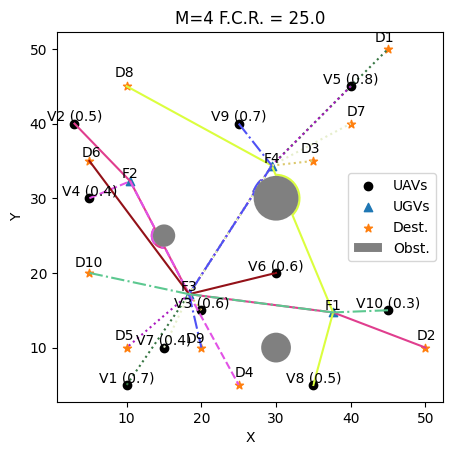

In [41]:
env.print_routs()
env.plot_routs(show_info=1,show_nums=0,save=1,show_ugv=0)

In [42]:
print('total cost: ',env.return_total_cost())
print('If all drones went directly to destintaion the cost would be: ',env.return_direct_cost())

total cost:  438.2563087455
If all drones went directly to destintaion the cost would be:  401.98153707341476


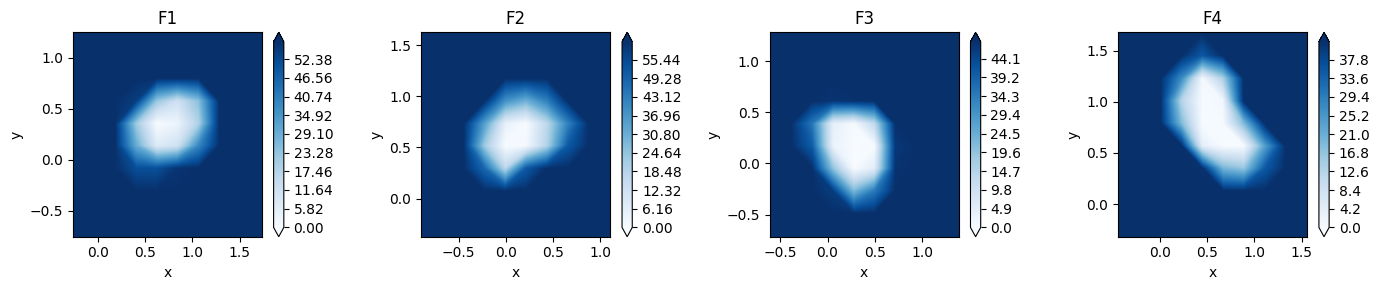

In [98]:


params_opt = env.params



# Initialize the figure for 3 subplots (heatmaps) since we now have 6 parameters,

# making 3 pairs to vary

fig, axs = plt.subplots(1, 4, figsize=(14, 3))



# Create a meshgrid for the pair of parameters we want to vary, which was missing in the previous code





# Generate heatmaps for each pair of parameters out of the 6
radius = 1
for i, (x_param_idx, y_param_idx) in enumerate([(0, 1), (2, 3), (4, 5), (6,7)]):
    xx = np.linspace(params_opt[x_param_idx]-radius, params_opt[x_param_idx]+radius, 10)
    yy = np.linspace(params_opt[y_param_idx]-radius, params_opt[y_param_idx]+radius, 10)
    X, Y = np.meshgrid(xx, yy)
    Z = np.zeros_like(X)  # Initialize function value matrix
    for x_idx, x in enumerate(xx):
        for y_idx, y in enumerate(yy):
            # Create an array with all parameters set to their corresponding value in 'params_opt'
            params = params_opt.copy()
            # Set the two parameters we are varying to their respective values in the grid
            params[x_param_idx] = x
            params[y_param_idx] = y

            # Compute the function value with these parameters
            Z[x_idx, y_idx] = env.objective(params.reshape(-1,2),1e-1)

    # Plot heatmap
    ax = axs.flat[i]  # Use flat indexing since we have a 2x2 subplot array
    c = ax.contourf(X, Y, Z,1000, cmap='Blues',extend='both')
    ax.set_title(f'F{i+1}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(c, ax=ax)

# Hide the last subplot as it's not needed
#axs[1, 1].axis('off')

# Display the plots
plt.tight_layout()
plt.show()

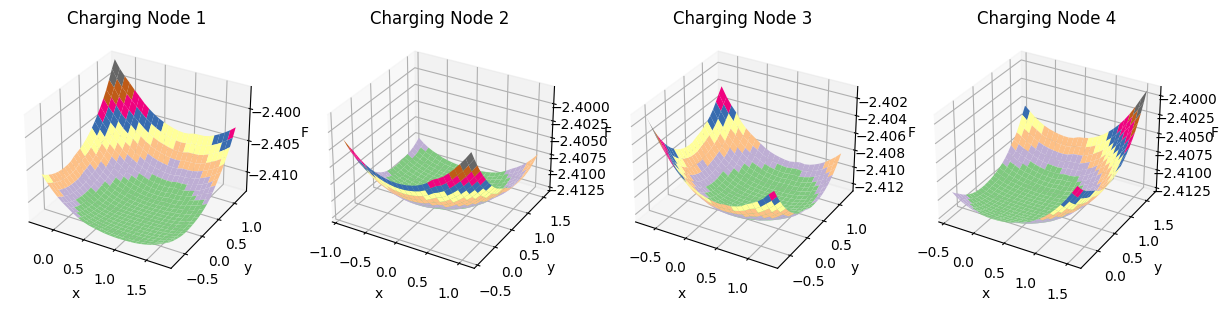

In [29]:
from mpl_toolkits.mplot3d import Axes3D
params_opt = env.params
# Adjust the grid range for 3D plot resolution


# Initialize the figure for 3 subplots (3D plots)
fig = plt.figure(figsize=(15,5))
r=1
# Generate 3D plots for each pair of parameters out of the 6
for i, (x_param_idx, y_param_idx) in enumerate([(0, 1), (2, 3), (4, 5),(6,7)]):
    # Create a meshgrid for the pair of parameters we want to vary
    xx = np.linspace(params_opt[x_param_idx]-r, params_opt[x_param_idx]+r, 25)
    yy = np.linspace(params_opt[y_param_idx]-r, params_opt[y_param_idx]+r, 25)
    X, Y = np.meshgrid(xx, yy)
    Z = np.zeros_like(X)  # Initialize function value matrix

    for x_idx, x in enumerate(xx):
        for y_idx, y in enumerate(yy):
            # Create an array with all parameters set to their corresponding value in 'params_opt'
            params = params_opt.copy()
            # Set the two parameters we are varying to their respective values in the grid
            params[x_param_idx] = x
            params[y_param_idx] = y

            # Compute the function value with these parameters
            Z[x_idx, y_idx] = env.objective(params.reshape(-1,2), 1e-8)

    # Create a 3D subplot
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='Accent', edgecolor='none')
    ax.set_title(f'Charging Node {i+1}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('F')
    #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    #ax.axis('off')



# Display the plots
#plt.tight_layout()
plt.show()